# EC-MIRI GTO : NIRISS WG - z>7 yield predictions

The purpose of this notebook is to predict the number density of LAEs/LBGs in (deep) NIRISS pointings for the purpose of simulating and exploiting the NIRISS-parallels of the EC-MIRI GTO observations.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.integrate import quad, romberg
from scipy.interpolate import interp1d
from astropy.cosmology import LambdaCDM

cosmo = LambdaCDM(Om0=0.3, Ode0=0.7, H0=70)

NIRISS_FoV = (2.2*u.arcmin)**2
#print(NIRISS_FoV.to(u.steradian))
#print((u.Jy).to( u.erg / u.cm**2/ u.s /u.Hz))

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3.5

### z>7 LBG yield in NIRISS data

- How many LBGs can be detected in the WFSS mode to get grims-redshift, lines EW, etc.. ?
- How many LBGs can be detected in the imaging data for future follow-up or stacking in the WFSS data?

I will simply use here the UVLF from Bouwens+2021 and its empirical redshift evolution model, integrated down to the proper magnitude and redshift limits for the survey.

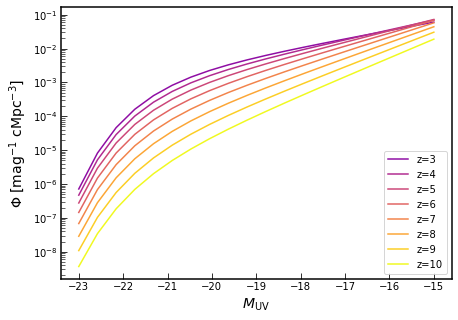

Please compare to Bouwens+21, Fig. 5


In [2]:
def schechter_M(M,phi_star,M_star,alpha):
    return phi_star *(np.log(10)/2.5) * (10**(-0.4*(M-M_star)*(alpha+1))) * np.exp(-10**(-0.4*(M-M_star)))

def M_UV_star(z):
    # in M_AB
    if z<2.46:
        return -20.89-1.09*(z-2.46)
    else: 
        return -21.03-0.04*(z-6)
def phi_star_UV(z):
    # in cMpc^{-3}
    return 0.4e-3 * (10**(-0.33*(z-6) - 0.024*(z-6)**2))
def alpha_UV(z):
    return -1.94 -0.11*(z-6)

def schechter_UV(M,z):
    mstar = M_UV_star(z)
    phistar = phi_star_UV(z)
    a = alpha_UV(z)
    return schechter_M(M,phi_star=phistar, alpha=a, M_star=mstar)
    

######################################
## just testing the empirical UVLFs ##

cm = plt.get_cmap('plasma')

M_UV = np.linspace(-23,-15,20)
figure = plt.figure(figsize=(7,5))
for z in np.arange(3,11):
    plt.plot(M_UV, schechter_UV(M_UV,z),color=cm(z/10), label='z='+str(z))
plt.legend()
plt.yscale('log')
plt.xlabel(r'$M_{\rm{UV}}$',fontsize=14)
plt.ylabel(r'$\Phi$ [mag$^{-1}$ cMpc$^{-3}$]', fontsize=14)
plt.show()
print('Please compare to Bouwens+21, Fig. 5')

In [3]:
def M_uv_lim(z, m_lim):
    # assuming a flat spectrum for the K-correction here (e.g. f_nu ~ const or f_lambda ~ lambda^2, e.g. \beta=2, Bouwens+2014, Stefanon+2021)
    return m_lim - 5*np.log10(cosmo.luminosity_distance(z).value*1e6/10 ) + 2.5*np.log10((1+z))
                   
print('Test:', M_uv_lim(z=6,m_lim=28.5),M_uv_lim(z=7,m_lim=25.5),M_uv_lim(z=7,m_lim=26.5))

def N_LBG_per_z1z2(z1,z2, m_lim):
    dndl = lambda z: quad(schechter_UV,-25,M_uv_lim(z,m_lim),args=z)[0]*(u.Mpc**(-3)) \
    *cosmo.differential_comoving_volume(z) * NIRISS_FoV.to(u.steradian)
    vol = lambda z: cosmo.differential_comoving_volume(z) * NIRISS_FoV.to(u.steradian)*(u.Mpc**(-3))
    #print(quad(vol, z1,z2)[0])
    return quad(dndl,z1,z2)[0] #,quad(vol, z1,z2)[0]

print('How many z>7 LBGs do we expect in the NIRISS WFSS parallels?')

print('F115W (7.45<z<9.55), N_LBGs - 5sigma continuum per spectral element  : ', N_LBG_per_z1z2(7.45,9.55, m_lim=25.8))
print('F150W (9.98<z<12.7), N_LBGs - 5sigma continuum per spectral element  : ', N_LBG_per_z1z2(9.98,12.7, m_lim=25.5))
print('F200W (13.45<z<17.5), N_LBGs - 5sigma continuum per spectral element : ', N_LBG_per_z1z2(13.45,17.5, m_lim=24.97))

print('F115W (7.45<z<9.55), N_LBGs - 4sigma continuum per spectral element : ', N_LBG_per_z1z2(7.45,9.55, m_lim=25.8-2.5*np.log10(4./5)))
print('F150W (9.98<z<12.7), N_LBGs - 4sigma continuum per spectral element : ', N_LBG_per_z1z2(9.98,12.7, m_lim=25.5-2.5*np.log10(4./5)))
print('F200W (13.45<z<17.5), N_LBGs - 4sigma continuum per spectral element : ', N_LBG_per_z1z2(13.45,17.5, m_lim=24.97-2.5*np.log10(4./5)))

print('F115W (7.45<z<9.55), N_LBGs - 3sigma continuum per spectral element : ', N_LBG_per_z1z2(7.45,9.55, m_lim=25.8-2.5*np.log10(3./5.)))
print('F150W (9.98<z<12.7), N_LBGs - 3sigma continuum per spectral element : ', N_LBG_per_z1z2(9.98,12.7, m_lim=25.5-2.5*np.log10(3./5.)))
print('F200W (13.45<z<17.5), N_LBGs - 3sigma continuum per spectral element : ', N_LBG_per_z1z2(13.45,17.5, m_lim=24.97-2.5*np.log10(3./5.)))

print('F115W (7.45<z<9.55), N_LBGs - 2sigma continuum per spectral element : ', N_LBG_per_z1z2(7.45,9.55, m_lim=25.8-2.5*np.log10(2./5.)))
print('F150W (9.98<z<12.7), N_LBGs - 2sigma continuum per spectral element : ', N_LBG_per_z1z2(9.98,12.7, m_lim=25.5-2.5*np.log10(2./5.)))
print('F200W (13.45<z<17.5), N_LBGs - 2sigma continuum per spectral element : ', N_LBG_per_z1z2(13.45,17.5, m_lim=24.97-2.5*np.log10(2./5.)))

print('F115W (7.45<z<9.55), N_LBGs - 1sigma continuum per spectral element : ', N_LBG_per_z1z2(7.45,9.55, m_lim=25.8-2.5*np.log10(1./5.)))
print('F150W (9.98<z<12.7), N_LBGs - 1sigma continuum per spectral element : ', N_LBG_per_z1z2(9.98,12.7, m_lim=25.5-2.5*np.log10(1./5.)))
print('F200W (13.45<z<17.5), N_LBGs - 1sigma continuum per spectral element : ', N_LBG_per_z1z2(13.45,17.5, m_lim=24.97-2.5*np.log10(1./5.)))

print('F115W (7.45<z<9.55), N_LBGs - 0.5sigma continuum per spectral element : ', N_LBG_per_z1z2(7.45,9.55, m_lim=25.8-2.5*np.log10(0.5/5.)))
print('F150W (9.98<z<12.7), N_LBGs - 0.5sigma continuum per spectral element : ', N_LBG_per_z1z2(9.98,12.7, m_lim=25.5-2.5*np.log10(0.5/5.)))
print('F200W (13.45<z<17.5), N_LBGs - 0.5sigma continuum per spectral element : ', N_LBG_per_z1z2(13.45,17.5, m_lim=24.97-2.5*np.log10(0.5/5.)))


Test: -18.194204015824308 -21.43717556107731 -20.43717556107731
How many z>7 LBGs do we expect in the NIRISS WFSS parallels?
F115W (7.45<z<9.55), N_LBGs - 5sigma continuum per spectral element  :  0.07468434470825312
F150W (9.98<z<12.7), N_LBGs - 5sigma continuum per spectral element  :  0.0004014757279398605
F200W (13.45<z<17.5), N_LBGs - 5sigma continuum per spectral element :  2.1803630610535782e-08
F115W (7.45<z<9.55), N_LBGs - 4sigma continuum per spectral element :  0.13784845962425732
F150W (9.98<z<12.7), N_LBGs - 4sigma continuum per spectral element :  0.0009636302773244517
F200W (13.45<z<17.5), N_LBGs - 4sigma continuum per spectral element :  9.322659029343688e-08
F115W (7.45<z<9.55), N_LBGs - 3sigma continuum per spectral element :  0.279218240852257
F150W (9.98<z<12.7), N_LBGs - 3sigma continuum per spectral element :  0.002593736300183016
F200W (13.45<z<17.5), N_LBGs - 3sigma continuum per spectral element :  4.61053766371565e-07
F115W (7.45<z<9.55), N_LBGs - 2sigma conti

### Low numbers! Is this compatible with Schmidt+2016 (HST Grism of HFF )?:
https://iopscience.iop.org/article/10.3847/0004-637X/818/1/38#apj521744s11

They report an observed 1sigma limit of 5e-18 cgs (e.g. our 5sigma), without magnification - usually 2-4, hence we go 2x deeper in intrinsic flux/magnitude. They find 24 "Silver" and 6 "Gold" objects over 6 HFF, so 6/1 per field. Our numbers are consistent, especially if we use sources at with continuum at SNR~0.5 in the continuum (the Lyman-alpha line would be detected at SNR>2). We might get a bit more, ~ e.g. 10-15 if 1) these galaxies have large EW 2) they live in ionised bubbles.

### In details:

- Lyman-alpha fraction. We aim to compute the Lyman-alpha fraction evolution with redshift. Typically, a threshold of EW_rest> 25 Angtroms is chosen. Here at R=150 that would mean that the spectral element containing Lyman-alpha would be (3+1)=4 times higher that of the remainder of the continuum value (if the break if exactly at the edge, etc..). So at SNR = 1 we can have the Lyman-alpha spectral element at SNR~3, and then stack multiple bins on the continuum to get SNR>5 and a good EW measurement. Typically we expect ~30% LBGs with Lyman-alpha at z=7 and ~0% at z=10 (e.g. de Barros+17, Laporte+2021 for good summary plots).
- Rest-frame UV lines: similar scenario here. The usual rest-frame UV lines EW from XShooter are 5-20 (e.g. Laporte+17, Stark+17, Hutchison+19). So these lines would be detected in a single bin at SNR=2-4 (if the continuum is at SNR=1) and we can repeat the trick above to get a SNR>5 continuum value. We can then stack the 30% times 44=13 with Lyman-alpha to get UV lines, or simply stack all LBGs to get UV lines, especially CIV/HeII. CIII] doublet will be blended, which will help.
- Potential for reionisation topology result: The ionised bubbles in the reionisation era are of the order of the pMpc. The FoV covers 0.6x0.6 Mpc at z~8. Potentially we could see multiple sources at the same redshift all with Lyman-alpha, and at another redshift multiple sources without Lyman-alpha. Could then be interpreted with simulations. Cool, but rather unlikely given the numbers at hand I think.

In [4]:
############## IMAGING - LBG selection at z>10

print('F115W (7.45<z<9.55), N_LBGs - 5sigma continuum in imaging : ',N_LBG_per_z1z2(7.45,9.55, m_lim=28.8))
print('F150W (9.98<z<12.7), N_LBGs - 5sigma continuum in imaging : ',N_LBG_per_z1z2(9.98,12.7, m_lim=28.23))
print('F200W (13.45z<17.5), N_LBGs - 5sigma continuum in imaging : ',N_LBG_per_z1z2(13.45,17.5, m_lim=28.49))

print('F115W (7.45<z<9.55), N_LBGs - 3sigma continuum in imaging : ',N_LBG_per_z1z2(7.45,9.55, m_lim=28.8 -2.5*np.log10(3./5.)))
print('F150W (9.98<z<12.7), N_LBGs - 3sigma continuum in imaging : ',N_LBG_per_z1z2(9.98,12.7, m_lim=28.23-2.5*np.log10(3./5.)))
print('F200W (13.45z<17.5), N_LBGs - 3sigma continuum in imaging : ',N_LBG_per_z1z2(13.45,17.5, m_lim=28.49-2.5*np.log10(3./5.)))


F115W (7.45<z<9.55), N_LBGs - 5sigma continuum in imaging :  12.975150098174035
F150W (9.98<z<12.7), N_LBGs - 5sigma continuum in imaging :  0.2628999018920252
F200W (13.45z<17.5), N_LBGs - 5sigma continuum in imaging :  0.0020210459575602346
F115W (7.45<z<9.55), N_LBGs - 3sigma continuum in imaging :  25.637639509449176
F150W (9.98<z<12.7), N_LBGs - 3sigma continuum in imaging :  0.6336518918746905
F200W (13.45z<17.5), N_LBGs - 3sigma continuum in imaging :  0.00581336271973924


### LBG with NIRISS imaging -  conclusion: 
With the imaging we might get 1 LBG at z>10. For z<10 we will need good non-detections with ancillary data. These numbers are overestimated since the observed magnitude will drop as the redshift increases and Lyman-alpha Break moves into the filter.

### LAE LF modelling: generalities

The Lyman-alpha Emitter Luminosity Function (LAE LF) is measured up to z=6 (e.g. SILVERRUSH; Konno+18 or the MUSE-wide/deep efforts; Drake+17, de La Vieuville+19, Herenz+19,etc..), and somwhat at z=7.3 (SILVERRUSH, Goto+21).

The main issue is that the Lyman-Alpha emission is difficult to measure without spectroscopy or appropriate NB filters, and that the evolution of the LAE LF cannot be predicted easily for 2 main reasons.

- 1) The IGM changes rapidly at z>6, affecting the number of galaxies observed in Lyman-alpha emission
- 2) The fraction of escaping Lyman-alpha radiation might change at high-z, which could be degenerate with an evolution in the number density and the IGM opacity.

The IGM opacity evolution is more or less constrained, but not the Lyman-alpha properties of galaxies.

### In practice

We will follow the recipe of Goto+2021 (see also Morales+2021: we will assume that the number of intrisic LAE evolves as the UVLF (measured up to z~10), scale to the 5.6-6.6 LAE LF from SILVERRUSH, and we will then apply the IGM opacity correction to get the final numbers.

The UVLF evolution is from the Bouwens+2021 empirical model (https://ui.adsabs.harvard.edu/abs/2021AJ....162...47B/abstract). The IGM neutral fraction curve is from Naidu+2019 (Model I neutral fraction history). 

NB1: This is in fact postulating that the f_esc(Ly-alpha) is fixed with redshift. Most studies would however suggest that f_esc(Ly-alpha) increases with redshift such that these numbers would be slightly underestimated in that sense.
NB2: Due to the complex reionisation topology, the transmission in bubbles and voids it is quite possible that these numbers will be completely off for a small field of view (e.g. deep NIRISS). They could be higher or lower depending on our luck - a good upper value can be obtained be neglecting IGM absorption, which I discuss later. For reference, at z=7.5, ~80% of the Lyman-alpha line will be absorbed.



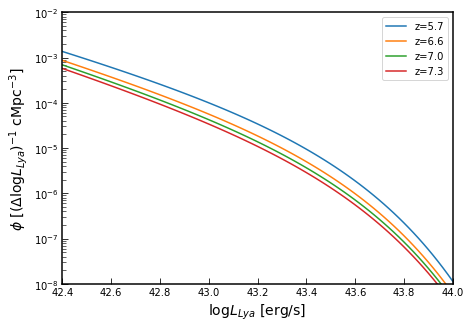

Please compare to Konno+18, Fig.9


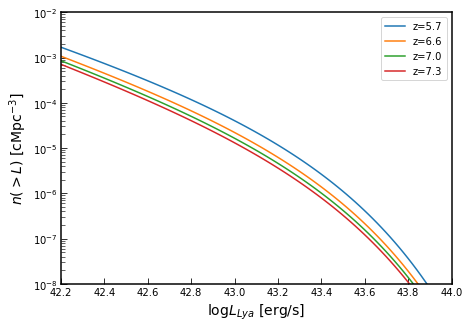

Please compare to Goto+21, Fig. 6 (low-z only, z=7.3 is affected by IGM)


In [5]:
def schechter_L(L,phi_star,L_star, alpha):
    return phi_star * (L/L_star)**alpha * np.exp(-L/L_star) /L_star

def schechter_LAE(L,z):
    # first we define the phi_star, L_star, alpha_star from Konno+18
    phi_star_5p7 = 0.849e-4 # cMpc^{-3}
    L_star_5p7 = 1.64e43 #erg^{s-1}
    alpha_5p7 = -2.56
#     #Herenz+19
#     phi_star_5p7 = 10**(-2.71) # cMpc^{-3}
#     L_star_5p7 = 10**42.66 #erg^{s-1}
#     alpha_5p7 = -1.84
    
    #### now, we rescale parameters according to the UVLF evolution
    phi_star_z = phi_star_5p7 * phi_star_UV(z)/phi_star_UV(5.7)
    L_star_z = L_star_5p7 * 10**(-0.4*(M_UV_star(z)-M_UV_star(5.7)))
    alpha_z = alpha_5p7 + alpha_UV(z)-alpha_UV(5.7)
    # and then return the intrinsic LAE LF
    return schechter_L(L,phi_star=phi_star_z, L_star= L_star_z, alpha=alpha_z)

#########################################
#### testing the LAE LF model ###########

L_Lya = 10**np.linspace(42,44,100)

figure=plt.figure(figsize=(7,5))
for z in [5.7,6.6, 7.0,7.3]:
    phi_L = schechter_LAE(L_Lya,z)
    plt.plot(np.log10(L_Lya), phi_L*L_Lya,label='z='+str(z))
    plt.legend()
    plt.yscale('log')
    plt.xlim(42.4,44)
    plt.ylim(1e-8,1e-2)
plt.ylabel(r'$\phi$ [$(\Delta \log L_{Lya})^{-1}$ cMpc$^{-3}$]',fontsize=14)
plt.xlabel(r'$\log L_{Lya}$ [erg/s]',fontsize=14)
plt.show()

print('Please compare to Konno+18, Fig.9')

figure=plt.figure(figsize=(7,5))
for z in [5.7,6.6, 7.0,7.3]:
    n_L = np.array([quad(schechter_LAE,L,10**45,args=z)[0] for L in L_Lya])
    plt.plot(np.log10(L_Lya), n_L,label='z='+str(z))
plt.legend()
plt.yscale('log')
plt.xlim(42.2,44)
plt.ylim(1e-8,1e-2)
plt.ylabel(r'$n(>L)$ [cMpc$^{-3}$]',fontsize=14)
plt.xlabel(r'$\log L_{Lya}$ [erg/s]',fontsize=14)
plt.show()

print('Please compare to Goto+21, Fig. 6 (low-z only, z=7.3 is affected by IGM)')
    
    
    

I now fit the mean x_HI fraction quickly, taking a spline of the Dexterized version of Naidu+2019 model I 
(one of the most rapidly evolving models, so understimating the LAE numbers in the worst case)

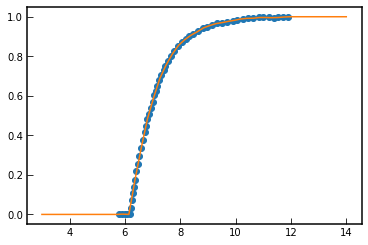

In [6]:
x_HI_data = np.loadtxt('x_HI_Naidu19_modelI.txt', skiprows=1)

x_HI = interp1d(np.concatenate(([3,4,5],x_HI_data[:,0],[12,13,14,18])),np.concatenate(([0,0,0],x_HI_data[:,1],[1,1,1,1])))

plt.scatter(x_HI_data[:,0],x_HI_data[:,1])
plt.plot(np.linspace(3,14), x_HI(np.linspace(3,14)), color='C1',zorder=10) 
plt.show()

Not bad. But note that this is a spline, so small wiggles are present... 
A proper fit would be nice, but then you would need to code some sort of functional form - sigmoid * step function probably.
Also note that the abrupt end of reionisation at z~6 is inconsistent with the quasar opacity measurements (e.g. Bosman+21, Yang+21), but this is often the case with these 1-D models (which sometimes don't even fit that kind of data). Not an issue here since we can only detect z>7 LAEs with NIRISS!

OK, now, let's get our end product - the observed LAE LF. To do that, we take the approximation from Dijkstra+2014  for the effective optical depth at the Lyman-alpha line wavelength (eq.30), assuming $\Delta v_{Lya-systemic}=200\ \rm{km/s}$. Nothing more fancy here because we care mostly about the overall flux since the resolution of NIRISS is R=150 ~ 2000 km/s!

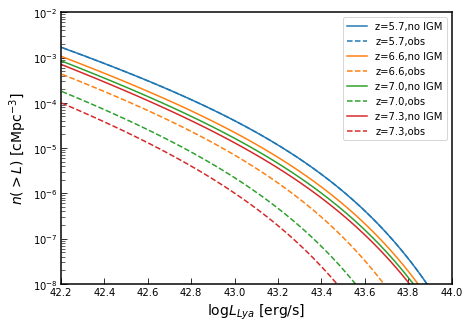

Please compare to Goto+21, Fig. 6 (low-z only, z=7.3 is affected by IGM)


In [7]:
def optical_depth(z):
    delta_v = 200 +(cosmo.H(z)*(u.Mpc*(1+z))/(1+z)).value # kms # Delta_v_photonredshift = H*R_bubble(cMpc)/(1+z)
    return 2.3*x_HI(z)*((delta_v/600)**(-1)) *((1+z)/10)**(3/2)

def obs_schechter_LAE(L_obs,z):
    L_intrinsic = L_obs / np.exp(-optical_depth(z))
    return schechter_LAE(L_intrinsic,z)


figure=plt.figure(figsize=(7,5))
for z,c in zip([5.7,6.6, 7.0,7.3],['C0','C1','C2','C3']):
    n_L = np.array([quad(schechter_LAE,L,10**45,args=z)[0] for L in L_Lya])
    plt.plot(np.log10(L_Lya), n_L,label='z='+str(z)+',no IGM', linestyle='-',color=c)
    n_L = np.array([quad(obs_schechter_LAE,L,10**45,args=z)[0] for L in L_Lya])
    plt.plot(np.log10(L_Lya), n_L,label='z='+str(z)+',obs', linestyle='--',color=c)
plt.legend()
plt.yscale('log')
plt.xlim(42.2,44)
plt.ylim(1e-8,1e-2)
plt.ylabel(r'$n(>L)$ [cMpc$^{-3}$]',fontsize=14)
plt.xlabel(r'$\log L_{Lya}$ [erg/s]',fontsize=14)
plt.show()

print('Please compare to Goto+21, Fig. 6 (low-z only, z=7.3 is affected by IGM)')    

Now, let's setup the parameters of our observations with NIRISS and make some cool predictions.

In [8]:
#### just some tests here on the limiting flux / magnitude of the observations

# f_nu = ((10**(-25.7/2.5))*3631*(u.Jy)).to( u.erg / u.cm**2 / u.s/u.Hz) 
# print('Flux density in cgs from magnitude',f_nu)
# f_lambda= (f_nu / ((1216*(1+7)*u.Angstrom)**2 /(3e8*u.m*u.Hz))).to(u.erg / u.cm**2 / u.s/u.Angstrom) 
# print('Flux density in f_lambda', f_lambda)
# print('Flux density ', f_lambda *1216*(1+7)*u.Angstrom /150 )

# print( ([1150] * u.nm).to(u.Hz, equivalencies=u.spectral())* 2000/3e5  * ((10**(-25.5/2.5))*3631*u.Jy).to( u.erg / u.cm**2 / u.s/u.Hz))
# print( ([1150] * u.nm).to(u.Hz, equivalencies=u.spectral())* 2000/3e5  * ((10**(-25.5/2.5))*3631*u.Jy).to( u.erg / u.cm**2 / u.s/u.Hz))



In [9]:
F115W_5sigma = 5.5e-18 * u.erg / u.cm**2 / u.s 
F150W_5sigma = 3.6e-18 * u.erg / u.cm**2 / u.s
F200W_5sigma = 3.9e-18 * u.erg / u.cm**2 / u.s

def f_lim(z):
    # here i'm taking into account the gaps between the filter, use lambda_cen -+ FWHM/2 as the edges
    lambda_lya = (1+z)*1215.67
    if lambda_lya > 10244 and lambda_lya < 12828:
        return F115W_5sigma
    elif lambda_lya > 13321 and lambda_lya < 16707:
        return F150W_5sigma
    elif lambda_lya > 17531 and lambda_lya < 22602:
        return F200W_5sigma
    else:
        return np.nan

z_bins_edges = np.linspace(7.4,17.4,51) #delta_z = 0.2

def flux_to_lum(flux,z):
    return (flux * 4*np.pi* (cosmo.luminosity_distance(z).to(u.cm))**2)

#print(flux_to_lum(F115W_5sigma,7.4),flux_to_lum(F115W_5sigma,10))

def N_LAEs_per_z1z2(z1,z2, SNR=5):
    
    dndz = lambda z: quad(obs_schechter_LAE,flux_to_lum(flux=f_lim(z)/5 *SNR,z=z).value,10**45,args=z)[0]*(u.Mpc**(-3)) \
            *cosmo.differential_comoving_volume(z) * NIRISS_FoV.to(u.steradian)
#     print((cosmo.comoving_distance(z2)-cosmo.comoving_distance(z1)) 
#             *(cosmo.kpc_comoving_per_arcmin((z1+z2)/2)**2).to(u.Mpc**2 / u.arcmin**2) * NIRISS_FoV)
#     dv = lambda z: cosmo.differential_comoving_volume(z) * NIRISS_FoV.to(u.steradian)*(u.Mpc**(-3))
#     print(quad(dv, z1,z2)[0])
    return (quad(dndz,z1,z2)[0])  

print('F115W (7.45<z<9.55), N_LAEs, SNR=5: ', N_LAEs_per_z1z2(7.45,9.55,SNR=5))
print('F150W (9.98<z<12.7), N_LAEs, SNR=5: ', N_LAEs_per_z1z2(9.98,12.7,SNR=5))
print('F200W (13.45z<17.5), N_LAEs, SNR=5: ', N_LAEs_per_z1z2(13.45,17.5,SNR=5))

print('F115W (7.45<z<9.55), N_LAEs, SNR=2: ', N_LAEs_per_z1z2(7.45,9.55,SNR=2))
print('F150W (9.98<z<12.7), N_LAEs, SNR=2: ', N_LAEs_per_z1z2(9.98,12.7,SNR=2))
print('F200W (13.45z<17.5), N_LAEs, SNR=2: ', N_LAEs_per_z1z2(13.45,17.5,SNR=2))


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


F115W (7.45<z<9.55), N_LAEs, SNR=5:  0.052629093841109906
F150W (9.98<z<12.7), N_LAEs, SNR=5:  0.0008871239527614852
F200W (13.45z<17.5), N_LAEs, SNR=5:  3.814108627761796e-07
F115W (7.45<z<9.55), N_LAEs, SNR=2:  0.4478104684366922
F150W (9.98<z<12.7), N_LAEs, SNR=2:  0.011248279934861148
F200W (13.45z<17.5), N_LAEs, SNR=2:  1.048325222282976e-05


### The LAE numbers - discussion on the assumptions

This is not very high! Note that even if we assume the IGM is fully ionised the numbers are N=0.77, 0.037, 4.5e-5 for F115W, F150W, F200W respectively . With no neutral IGM and the LAE LF is fixed at the z=5.7 value we get N=4.14,2.54,0.44. The numbers using the Herenz+19 LAE LF gives the same results within 10%.

### Quick order of magnitude check: 

MUSE-WIDE (https://www.aanda.org/articles/aa/full_html/2019/01/aa34164-18/aa34164-18.html) has 4.6x the NIRISS parallel area, and lower Lyman-alpha minimum luminosity (22.2 arcmin$^2$,$ L_{Lya} > 10^{42.2} \rm{erg s^{-1}}$). Their cumlative number density of LAEs(>10^42.2, 3<z<6) is $\phi~\times10^{-3} [\rm{cMpc}^{-3}]$. Our survey volume is about $2\times10^{4} [cMpc^{3}]$ per band, hence you would expect ~20 LAEs per filter in the absence of LAE LF evolution and the neutral IGM. However, our minimum detectable Lyman-alpha luminosity is higher (e.g. L>10^42.55 at z=7.4, 42.85 at z=10), hence the final numbers are much lower. Indeed, at z=7 the cumulative number of LAE with L>10^42.6 is ~10^{-4} (see plot above or Goto+21). Furthermore at z>7 the IGM is >50% neutral, and the Lyman-alpha absorption will be >80% (unless the galaxies live in very ionised bubbles, e.g. Mason+2020).

Note that the number of LAEs at SNR=2 (2.26) is compatible with ~20-30% Lyman-alpha fraction times the number of LBGs in the same redshift bin (6, SNR=0.5 continuum, SNR=2 for the line) see above.